# W200 Section1 Final Project

## Group1 - Danielle O'Neil, Irene Seo, Teresa Wang

In [1]:
!pwd

/Users/briannaseo/Desktop/W200.1


In [58]:
import numpy as np
import pandas as pd
import re
import statsmodels.formula.api as sm


pd.options.display.float_format = '{:,.2f}'.format

import matplotlib.pyplot as plt
%matplotlib inline  

print (np.__version__)

1.14.2


## 1. Data Exploration

In [3]:
titanic = pd.read_excel("titanic3.xls")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,2,female,29.00,0,0,24160,211.34,B5,S,2,nan,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,NaN,nan,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.55,C22 C26,S,NaN,135.00,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,NaN,nan,"Montreal, PQ / Chesterville, ON"


In [4]:
titanic.describe(include = "all")

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
count,"1,309.00","1,309.00",1309,1309,"1,046.00","1,309.00","1,309.00",1309,"1,308.00",295,1307,486,121.00,745
unique,nan,nan,1307,2,nan,nan,nan,939,nan,186,3,28,nan,369
top,nan,nan,"Connolly, Miss. Kate",male,nan,nan,nan,CA. 2343,nan,C23 C25 C27,S,13,nan,"New York, NY"
freq,nan,nan,2,843,nan,nan,nan,11,nan,6,914,39,nan,64
mean,2.29,0.38,NaN,NaN,29.88,0.50,0.39,NaN,33.30,NaN,NaN,NaN,160.81,NaN
std,0.84,0.49,NaN,NaN,14.41,1.04,0.87,NaN,51.76,NaN,NaN,NaN,97.70,NaN
min,1.00,0.00,NaN,NaN,0.17,0.00,0.00,NaN,0.00,NaN,NaN,NaN,1.00,NaN
25%,2.00,0.00,NaN,NaN,21.00,0.00,0.00,NaN,7.90,NaN,NaN,NaN,72.00,NaN
50%,3.00,0.00,NaN,NaN,28.00,0.00,0.00,NaN,14.45,NaN,NaN,NaN,155.00,NaN
75%,3.00,1.00,NaN,NaN,39.00,1.00,0.00,NaN,31.27,NaN,NaN,NaN,256.00,NaN


In [5]:
titanic.pclass.value_counts()

3    709
1    323
2    277
Name: pclass, dtype: int64

## 2. Data Cleansing

### 2.1. Converting variables in a sensible type

- pclass is a categorical variable, so we'll convert the type into "category" and add a new column.

In [6]:
ranges = [0,1,2,3]
labels = ["First","Second","Third"]
titanic["cabin_class"] = pd.cut(titanic.pclass, ranges, labels = labels).astype("category")
titanic.cabin_class.describe()

count      1309
unique        3
top       Third
freq        709
Name: cabin_class, dtype: object

- We'd like to define different age groups in order to proceed our data analyses.

In [7]:
age_range = [0,10,20,30,40,50,60,70,80]
age_labels = ["0-10","10-20","20-30","30-40","40-50","50-60","60-70","70-80"]
titanic["age_group"] = pd.cut(titanic.age, age_range, labels = age_labels).astype("category")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,cabin_class,age_group
0,1,1,2,female,29.00,0,0,24160,211.34,B5,S,2,nan,"St Louis, MO",First,20-30
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON",First,0-10
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,NaN,nan,"Montreal, PQ / Chesterville, ON",First,0-10
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.55,C22 C26,S,NaN,135.00,"Montreal, PQ / Chesterville, ON",First,20-30
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,NaN,nan,"Montreal, PQ / Chesterville, ON",First,20-30


- Some passengers had multiple values for `cabin`, and not all are formatted consistently. For the sake of this anaylsis, we're taking the first cabin listed for every passenger. Ultimately, we want to look at the deck the cabin was located on. Because class cabins spanned multiple decks, we want to look at how the deck of the cabin related to survival rate or whether or not a body was found.

In [8]:
titanic["deck"] = titanic["cabin"].str.slice(0,1)
titanic["room"] = titanic["cabin"].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,cabin_class,age_group,deck,room
0,1,1,2,female,29.00,0,0,24160,211.34,B5,S,2,nan,"St Louis, MO",First,20-30,B,5.00
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON",First,0-10,C,22.00
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,NaN,nan,"Montreal, PQ / Chesterville, ON",First,0-10,C,22.00
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.55,C22 C26,S,NaN,135.00,"Montreal, PQ / Chesterville, ON",First,20-30,C,22.00
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,NaN,nan,"Montreal, PQ / Chesterville, ON",First,20-30,C,22.00


Now that we have cabin and room broken apart, we want to make sure the decks fit into one of the valid classifications: A, B, C, D, E, and F. Based on research, we know these are the decks that had passenger cabins on the Titanic.

In [9]:
titanic.deck.value_counts()

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: deck, dtype: int64

Decks G and T are invalid, so we'll want to fix those. 

In [10]:
titanic[titanic["deck"]=="G"]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,cabin_class,age_group,deck,room
1187,3,1,"Sandstrom, Miss. Beatrice Irene",female,1.00,1,1,PP 9549,16.70,G6,S,13,nan,NaN,Third,0-10,G,6.00
1188,3,1,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.00,0,2,PP 9549,16.70,G6,S,13,nan,NaN,Third,20-30,G,6.00
1189,3,1,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,1,PP 9549,16.70,G6,S,13,nan,NaN,Third,0-10,G,6.00
1230,3,0,"Strom, Miss. Telma Matilda",female,2.00,0,1,347054,10.46,G6,S,NaN,nan,NaN,Third,0-10,G,6.00
1231,3,0,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.00,1,1,347054,10.46,G6,S,NaN,nan,NaN,Third,20-30,G,6.00


The passengers appearing to be in a cabin on the G deck were in 3rd class, so we're going to assume they were actually on deck F, the lowest 3rd class deck.

In [11]:
titanic["deck"] = titanic["deck"].replace("G", "F")
titanic.deck.value_counts()

C    94
B    65
D    46
E    41
F    26
A    22
T     1
Name: deck, dtype: int64

In [12]:
titanic[titanic["deck"]=="T"]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,cabin_class,age_group,deck,room
30,1,0,"Blackwell, Mr. Stephen Weart",male,45.00,0,0,113784,35.50,T,S,NaN,nan,"Trenton, NJ",First,40-50,T,nan


Conversely, the passenger with a cabin on the T deck is in 1st class, so we'll assume he was on the A deck, the highest first class deck.

In [13]:
titanic["deck"] = titanic["deck"].replace("T", "A")
titanic.deck.value_counts()

C    94
B    65
D    46
E    41
F    26
A    23
Name: deck, dtype: int64


- family data

In [14]:
titanic.sibsp.value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: sibsp, dtype: int64

In [15]:
titanic.parch.value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: parch, dtype: int64

### 2.2. Creating a new category

- Since we are interested in data analyses of 3 categories - "survived", "body found", "body missing", we create a new column for this new category.

In [16]:
survived = titanic.copy()[titanic.survived == 1]
body_found = titanic.copy()[(titanic.survived == 0) & (titanic.body.notnull())]
body_missing = titanic.copy()[(titanic.survived == 0) & (titanic.body.isnull())]
survived["status"] = "survived"
body_found["status"] = "body found"
body_missing["status"] = "body missing"
titanic = pd.merge(survived, body_found, how = "outer")
titanic = pd.merge(titanic, body_missing, how = "outer")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,cabin_class,age_group,deck,room,status
0,1,1,2,female,29.00,0,0,24160,211.34,B5,S,2,nan,"St Louis, MO",First,20-30,B,5.00,survived
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON",First,0-10,C,22.00,survived
2,1,1,"Anderson, Mr. Harry",male,48.00,0,0,19952,26.55,E12,S,3,nan,"New York, NY",First,40-50,E,12.00,survived
3,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.00,1,0,13502,77.96,D7,S,10,nan,"Hudson, NY",First,60-70,D,7.00,survived
4,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.00,2,0,11769,51.48,C101,S,D,nan,"Bayside, Queens, NY",First,50-60,C,101.00,survived


- We add up SIBSP and PARCH in order to show the total family numbers
- We extract the family name and create a new column "last_ name" in order to better verify if the passengers are families. 

In [17]:
titanic['last_name'] = titanic['name'].str.extract('^(.*),', expand = False)
titanic['family_number'] = titanic['sibsp'] + titanic['parch']

family_range = [-1, 0, titanic['name'].count()]

family_labels = ["No", "Yes"]
titanic["with_family"] = pd.cut(titanic.family_number, family_range, labels = family_labels).astype("category")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,...,body,home.dest,cabin_class,age_group,deck,room,status,last_name,family_number,with_family
0,1,1,2,female,29.00,0,0,24160,211.34,B5,...,nan,"St Louis, MO",First,20-30,B,5.00,survived,NaN,0,No
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,...,nan,"Montreal, PQ / Chesterville, ON",First,0-10,C,22.00,survived,Allison,3,Yes
2,1,1,"Anderson, Mr. Harry",male,48.00,0,0,19952,26.55,E12,...,nan,"New York, NY",First,40-50,E,12.00,survived,Anderson,0,No
3,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.00,1,0,13502,77.96,D7,...,nan,"Hudson, NY",First,60-70,D,7.00,survived,Andrews,1,Yes
4,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.00,2,0,11769,51.48,C101,...,nan,"Bayside, Queens, NY",First,50-60,C,101.00,survived,Appleton,2,Yes


### 2.3. Define necessary functions to apply to dataframe

- Calculating percentage of a variable counts in order to draw proportional graphs in EDA.

In [18]:
def calc_pct(value, total):
    percentage = (value/total) * 100
    return percentage

## 3. Exploratory Data Analysis
### 3.1 Survival rate

In [19]:
# How many people in the dataset survived?
titanic.survived.value_counts() 

0    809
1    500
Name: survived, dtype: int64

In [20]:
# Of those who died, 688 went without being found
titanic.status.value_counts()

body missing    688
survived        500
body found      121
Name: status, dtype: int64

Text(0.5,1,'Passengers by survival status')

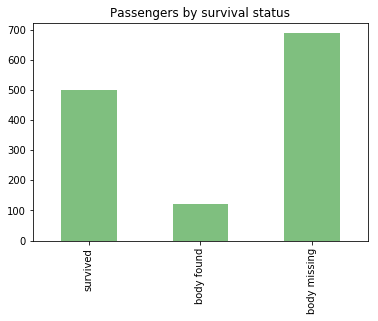

In [21]:
order = ["survived", "body found", "body missing"]
titanic.status.value_counts().loc[order].plot(kind = "bar", alpha=0.5, color = "g")
plt.title("Passengers by survival status")

### 3.2 Sex

In [22]:
titanic.sex.value_counts()

male      843
female    466
Name: sex, dtype: int64

Text(0.5,1,'Gender distribution of passengers')

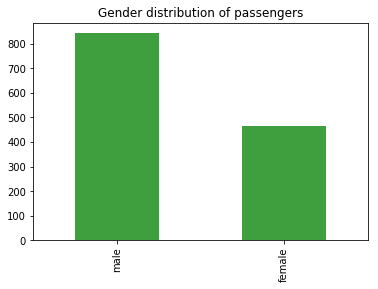

In [23]:
titanic.sex.value_counts().plot(kind="bar", alpha=0.5, color="g")
titanic.sex.value_counts().plot(kind="bar", alpha=0.5, color="g")

plt.title("Gender distribution of passengers")

In [24]:
titanic.groupby("sex").status.value_counts()

sex     status      
female  survived        339
        body missing    119
        body found        8
male    body missing    569
        survived        161
        body found      113
Name: status, dtype: int64

Text(0.5,1,'Survival status by gender')

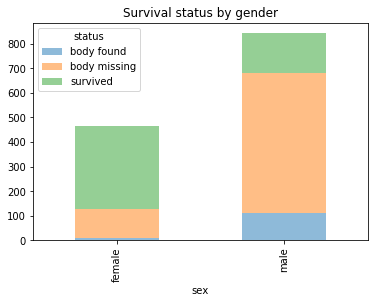

In [25]:
# Plot number of survivors, bodies found, and bodies missing by gender

titanic_sex = titanic.groupby(["sex","status"])["status"].count().unstack("status")
titanic_sex.plot(kind="bar", stacked=True, alpha=0.5)

plt.title("Survival status by gender")

Text(0.5,1,'Survival rate by gender')

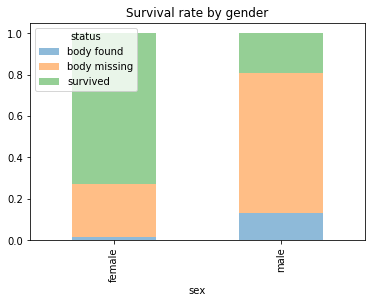

In [26]:
surv_pct_gender = pd.pivot_table(titanic, index='sex', columns='status', aggfunc='size')
surv_pct_gender = surv_pct_gender.div(surv_pct_gender.sum(axis=1), axis=0)
surv_pct_gender.plot(kind="bar", stacked=True, alpha=0.5)

plt.title("Survival rate by gender")

### 3.3 Age

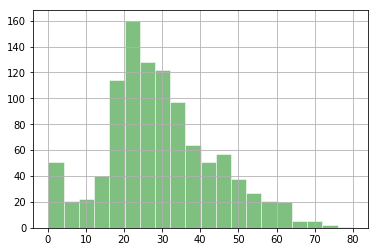

In [27]:
titanic.age.hist(bins = 20, color = "g", alpha=0.5, edgecolor="w")

In [28]:
titanic.age_group.value_counts()

20-30    361
30-40    210
10-20    162
40-50    132
0-10      86
50-60     62
60-70     27
70-80      6
Name: age_group, dtype: int64

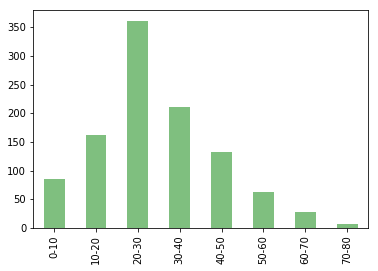

In [29]:
titanic.age_group.value_counts().loc[age_labels].plot(kind="bar", color="g", alpha=0.5)

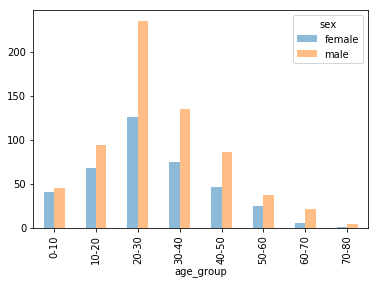

In [30]:
titanic_gender_age = titanic.groupby(["age_group", "sex"])["sex"].count().unstack("sex")
titanic_gender_age.plot(kind="bar", stacked=False, alpha=0.5)

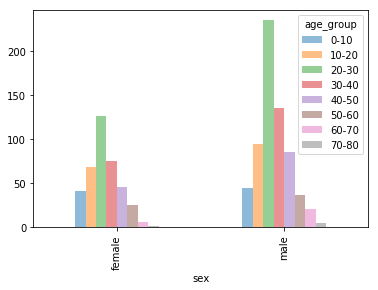

In [31]:
titanic_age_gender = titanic.groupby(["sex", "age_group"])["age_group"].count().unstack("age_group")
titanic_age_gender.plot(kind="bar", stacked=False, alpha=0.5)

In [32]:
titanic.groupby("age_group").status.value_counts()

age_group  status      
0-10       survived         50
           body missing     35
           body found        1
10-20      body missing     85
           survived         64
           body found       13
20-30      body missing    194
           survived        134
           body found       33
30-40      body missing     89
           survived         89
           body found       32
40-50      body missing     58
           survived         52
           body found       22
50-60      survived         30
           body missing     23
           body found        9
60-70      body missing     13
           body found        8
           survived          6
70-80      body found        2
           body missing      2
           survived          2
Name: status, dtype: int64

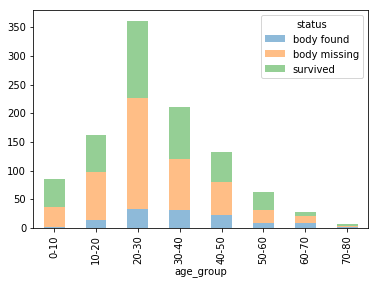

In [33]:
titanic_age = titanic.groupby(["age_group", "status"])["status"].count().unstack("status")
titanic_age.plot(kind="bar", stacked=True, alpha=0.5)

Text(0.5,1,'survival rate by age group')

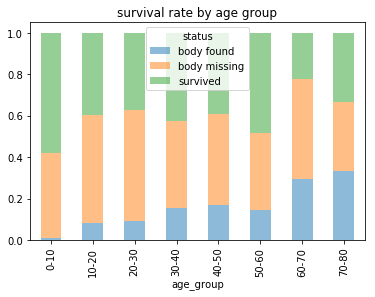

In [34]:
surv_pct_age = pd.pivot_table(titanic, index="age_group", columns="status", aggfunc="size")
surv_pct_age = surv_pct_age.div(surv_pct_age.sum(axis=1), axis=0)
surv_pct_age.plot(kind="bar", stacked=True, alpha=0.5)

plt.title("survival rate by age group")

Text(0.5,1,'Survivors by gender and by age group')

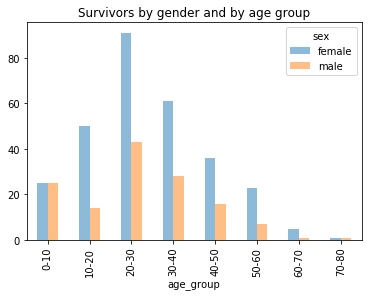

In [35]:
titanic_survived = titanic.copy()[titanic["status"] == "survived"]

surv_age_gender = titanic_survived.groupby(["age_group", "sex"])["sex"].count().unstack("sex")
surv_age_gender.plot(kind="bar", alpha=0.5)

plt.title("Survivors by gender and by age group")

### 3.4 Cabin Class

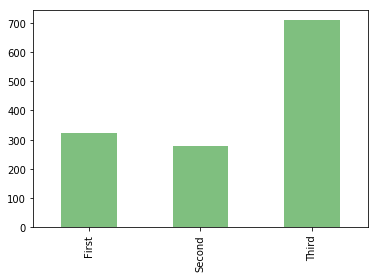

In [36]:
titanic.cabin_class.value_counts().loc[labels].plot(kind = "bar", color="g", alpha=0.5)

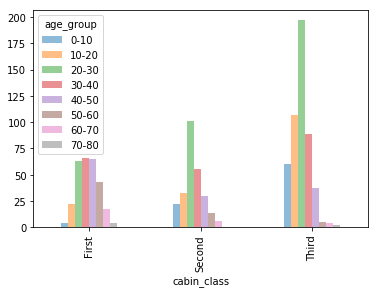

In [37]:
titanic_class_age = titanic.groupby(["cabin_class", "age_group"])["age_group"].count().unstack("age_group")
titanic_class_age.plot(kind="bar", stacked=False, alpha=0.5)

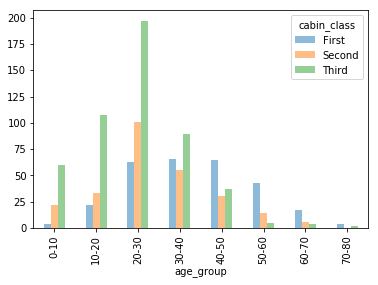

In [38]:
titanic_age_class = titanic.groupby(["age_group", "cabin_class"])["cabin_class"].count().unstack("cabin_class")
titanic_age_class.plot(kind="bar", stacked=False, alpha=0.5)

In [39]:
titanic.groupby("cabin_class").status.value_counts()

cabin_class  status      
First        survived        200
             body missing     88
             body found       35
Second       body missing    127
             survived        119
             body found       31
Third        body missing    473
             survived        181
             body found       55
Name: status, dtype: int64

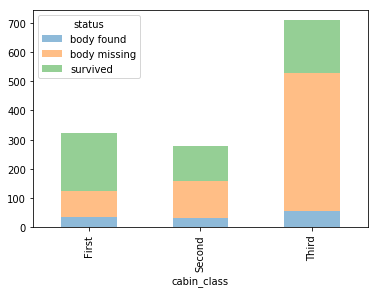

In [40]:
titanic_class = titanic.groupby(["cabin_class", "status"])["status"].count().unstack("status")
titanic_class.plot(kind="bar", stacked=True, alpha=0.5)

Text(0.5,1,'survival rate by cabin class')

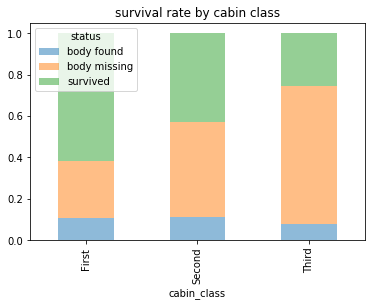

In [41]:
surv_pct_class = pd.pivot_table(titanic, index="cabin_class", columns="status", aggfunc="size")
surv_pct_class = surv_pct_class.div(surv_pct_class.sum(axis=1), axis=0)
surv_pct_class.plot.bar(stacked=True, alpha=0.5)

plt.title("survival rate by cabin class")

Text(0.5,1,'Survivors by gender and by cabin class')

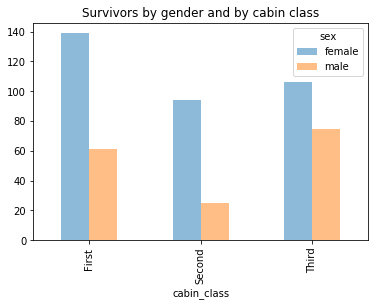

In [42]:
surv_gender_class = titanic_survived.groupby(["cabin_class", "sex"])["sex"].count().unstack("sex")
surv_gender_class.plot(kind="bar", alpha=0.5)

plt.title("Survivors by gender and by cabin class")

Text(0.5,1,'Survivors by cabin class and by age')

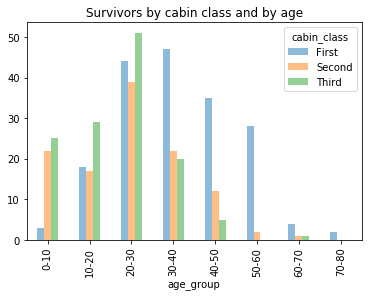

In [43]:
surv_age_class = titanic_survived.groupby(["age_group", "cabin_class"])["cabin_class"].count().unstack("cabin_class")
surv_age_class.plot(kind="bar", alpha=0.5)

plt.title("Survivors by cabin class and by age")

### 3.5 Family

In [44]:
titanic.with_family.value_counts()

No     790
Yes    519
Name: with_family, dtype: int64

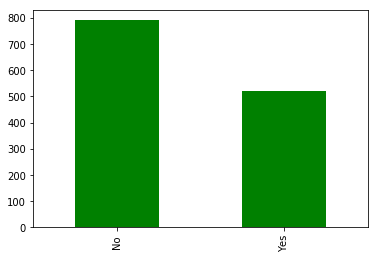

In [45]:
titanic.with_family.value_counts().plot(kind="bar", color="g")

In [46]:
titanic.groupby("with_family").status.value_counts()

with_family  status      
No           body missing    468
             survived        239
             body found       83
Yes          survived        261
             body missing    220
             body found       38
Name: status, dtype: int64

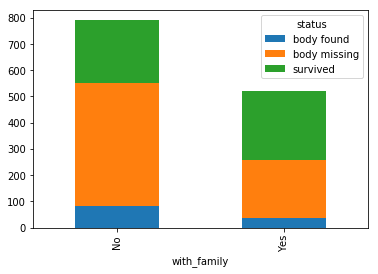

In [47]:
titanic_class = titanic.groupby(["with_family","status"])["status"].count().unstack("status")
titanic_class.plot(kind="bar", stacked=True)

In [48]:
# titanic.ticket.value_counts() 
titanic.groupby("ticket").with_family.value_counts()

ticket             with_family
695                No             1
5727               No             1
11751              Yes            2
11755              Yes            1
11767              Yes            1
11769              Yes            2
11770              Yes            1
11813              No             2
11967              Yes            2
13050              No             1
13502              Yes            1
13508              Yes            2
13905              No             1
16966              No             1
17474              Yes            2
17770              No             1
19877              Yes            2
                   No             1
19924              No             1
19952              No             1
24160              No             1
27042              No             1
33638              Yes            3
36928              No             1
36947              Yes            1
110152             No             1
110465             No            

In [49]:
titanic.last_name.value_counts() 

Sage          11
Andersson     11
Asplund        8
Goodwin        8
Davies         7
Carter         6
Rice           6
Ford           6
Skoog          6
Smith          6
Panula         6
Brown          6
Johnson        6
Fortune        6
Palsson        5
Thomas         5
Ryerson        5
Kelly          5
Lefebre        5
Williams       5
Elias          4
Dean           4
Johnston       4
Gustafsson     4
Olsen          4
Harris         4
West           4
Hansen         4
Cacic          4
Ware           4
              ..
Doyle          1
Lockyer        1
Riordan        1
Drapkin        1
de Brito       1
Reynolds       1
Serepeca       1
Widegren       1
Greenberg      1
Hagardon       1
Maioni         1
Foo            1
Charters       1
Brewe          1
Hood           1
Barah          1
Beavan         1
Ilieff         1
LeRoy          1
Sivic          1
Gheorgheff     1
Coleridge      1
Wilkes         1
Earnshaw       1
Aldworth       1
Parr           1
Spector        1
Rush          

In [50]:
# #convert to excel 
# df = pd.DataFrame(titanic)

# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('titanic_data.xlsx', engine='xlsxwriter')

# # Convert the dataframe to an XlsxWriter Excel object.
# df.to_excel(writer, sheet_name='Sheet1')

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

### 3.5.1 Family- SIBSP

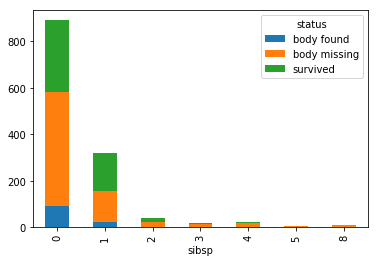

In [51]:
titanic_class = titanic.groupby(["sibsp","status"])["status"].count().unstack("status")
titanic_class.plot(kind="bar", stacked=True)

### 3.5.2 Family- PARCH

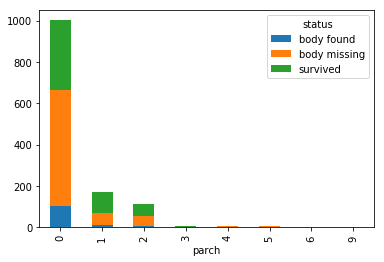

In [52]:
titanic_class = titanic.groupby(["parch","status"])["status"].count().unstack("status")
titanic_class.plot(kind="bar", stacked=True)

### 3.6 Deck

In [53]:
titanic.deck.value_counts()

C    94
B    65
D    46
E    41
F    26
A    23
Name: deck, dtype: int64

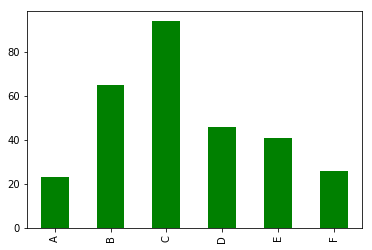

In [54]:
titanic.deck.value_counts().sort_index().plot(kind="bar", color="g")

In [55]:
titanic.groupby("deck").status.value_counts()

deck  status      
A     body missing    11
      survived        11
      body found       1
B     survived        47
      body missing    11
      body found       7
C     survived        57
      body missing    26
      body found      11
D     survived        32
      body missing     9
      body found       5
E     survived        30
      body missing     7
      body found       4
F     survived        16
      body missing     6
      body found       4
Name: status, dtype: int64

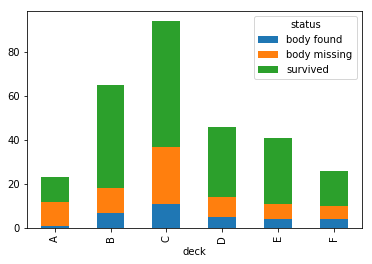

In [56]:
titanic_deck = titanic.groupby(["deck","status"])["status"].count().unstack("status")
titanic_deck.plot(kind="bar", stacked=True)

## 4. Correlations
### 4.1 Gender

In [62]:
model1 = sm.ols(formula="survived ~ sex", data=titanic).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     507.1
Date:                Wed, 11 Apr 2018   Prob (F-statistic):           3.78e-95
Time:                        17:11:06   Log-Likelihood:                -697.97
No. Observations:                1309   AIC:                             1400.
Df Residuals:                    1307   BIC:                             1410.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7275      0.019     38.049      0.000       0.690       0.765
sex[T.male]    -0.5365      0.024    -22.518      0.000      -0.583      -0.490
==============================================================================
Omnibus:                       37.339   Durbin-Watson:                   0.534
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.798
Skew:                           0.419   Prob(JB):                     2.28e-09
Kurtosis:                       2.834   Cond. No.                         3.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
titanic_notsurvived = titanic.copy()[titanic["survived"] == 0]
titanic_notsurvived.

count   809.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: survived, dtype: float64

In [65]:
model2 = sm.ols(formula="body_found ~ sex", data=titanic_notsurvived).fit()
model2.summary()

PatsyError: categorical data cannot be >1-dimensional

In [66]:
model3 = sm.ols(formula="survived ~ age", data=titanic).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.227
Date:                Wed, 11 Apr 2018   Prob (F-statistic):             0.0727
Time:                        17:12:30   Log-Likelihood:                -739.64
No. Observations:                1046   AIC:                             1483.
Df Residuals:                    1044   BIC:                             1493.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4648      0.035     13.291      0.000       0.396       0.533
age           -0.0019      0.001     -1.796      0.073      -0.004       0.000
==============================================================================
Omnibus:                       23.029   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.134
Skew:                           0.373   Prob(JB):                     2.54e-38
Kurtosis:                       1.151   Cond. No.                         76.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
model4 = sm.ols(formula="body_found ~ age", data=titanic_notsurvived).fit()
model4.summary()

PatsyError: categorical data cannot be >1-dimensional